In [1]:
import tqdm
import numpy as np
import scipy.stats
import pandas as pd
import sklearn
import sklearn.covariance
import networkx as nx
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
sns.set_style('ticks')
palette = sns.color_palette("RdBu_r", n_colors=25)
import plotly
plotly.offline.init_notebook_mode(connected=True)

import kliep

## Multivariate Gaussian 1

In [2]:
tmis = [-0.5 * np.log(1 - c**2) for c in np.arange(0, 1, 0.1)]

In [3]:
mis = []
for c in tqdm.tqdm(np.arange(0, 1, 0.1)):
    cov = np.array([[1, c], [c, 1]])
    XY = scipy.stats.multivariate_normal(mean=[0, 0], cov=cov).rvs(1000)
    X, Y = np.split(XY, [1], axis=1)
    mis += [kliep.mutual_information(X, Y, sigma=0.5)]

100%|██████████| 10/10 [00:05<00:00,  1.59it/s]


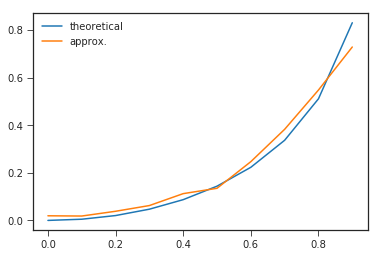

In [4]:
plt.plot(np.arange(0, 1, 0.1), tmis, label='theoretical')
plt.plot(np.arange(0, 1, 0.1), mis, label='approx.')
plt.legend()

## Multivariate Gaussian 2

In [5]:
pre = [[1,   0.5,    0],
       [0.5,   1, -0.4],
       [0,  -0.4,    1]]
cov = np.linalg.inv(pre)
print(np.array(pre))
X = scipy.stats.multivariate_normal(mean=[0, 0, 0], cov=cov).rvs(3000)

[[ 1.   0.5  0. ]
 [ 0.5  1.  -0.4]
 [ 0.  -0.4  1. ]]


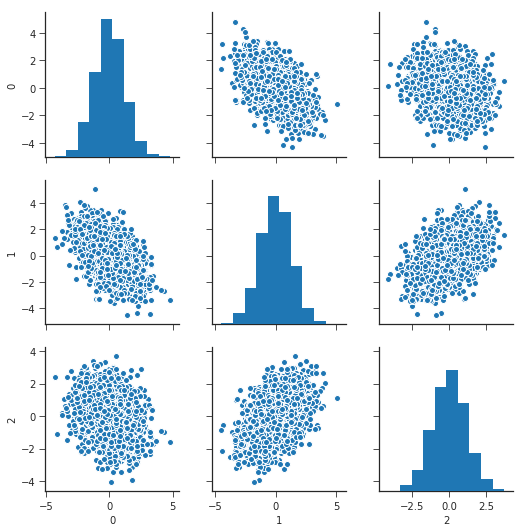

In [6]:
sns.pairplot(pd.DataFrame(X))

In [7]:
d = 3
mi = np.zeros([d, d])
cmi = np.zeros([d, d])
for i, j in tqdm.tqdm([(i, j) for i in range(d) for j in range(d) if i > j]):
    mi[i, j] = mi[j, i] = kliep.mutual_information(X=X[:, i].reshape(-1, 1), Y=X[:, j].reshape(-1, 1), maxiter=1000)
    mask = (np.arange(d) != i) & (np.arange(d) != j)
    mi_xz = kliep.mutual_information(X=X[:, i].reshape(-1, 1), Y=X[:, mask], maxiter=1000)
    mi_yz = kliep.mutual_information(X=X[:, j].reshape(-1, 1), Y=X[:, mask], maxiter=1000)
    mi_xyz = kliep.mutual_information(X=X[:, i].reshape(-1, 1), Y=X[:, j].reshape(-1, 1), Z=X[:, mask], maxiter=1000)
    cmi[i, j] = cmi[j, i] = mi_xyz - (mi_xz + mi_yz)
    cmi[cmi < 0] = 0

cmi

100%|██████████| 3/3 [00:14<00:00,  4.82s/it]


array([[ 0.        ,  0.12313436,  0.        ],
       [ 0.12313436,  0.        ,  0.07565519],
       [ 0.        ,  0.07565519,  0.        ]])

In [8]:
model = sklearn.covariance.GraphLasso(alpha=0.3)
model.fit(X)

GraphLasso(alpha=0.3, assume_centered=False, enet_tol=0.0001, max_iter=100,
      mode='cd', tol=0.0001, verbose=False)

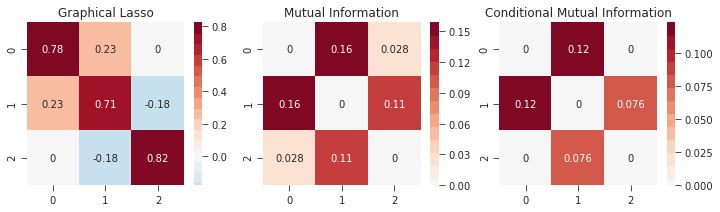

In [9]:
f, axes = plt.subplots(1, 3, figsize=[12, 3])
axes[0].set_title('Graphical Lasso')
axes[1].set_title('Mutual Information')
axes[2].set_title('Conditional Mutual Information')
sns.heatmap(model.precision_, annot=True, ax=axes[0], center=0, cmap=palette)
sns.heatmap(mi, annot=True, ax=axes[1], center=0, cmap=palette)
sns.heatmap(cmi, annot=True, ax=axes[2], center=0, cmap=palette)
plt.savefig('output/cmi.png', dpi=120)

## Multivariate Gaussian Mixuture

In [10]:
X1 = scipy.stats.multivariate_normal(mean=[-5,  0,  0], cov=np.eye(3)).rvs(500)
X2 = scipy.stats.multivariate_normal(mean=[+5,  0,  0], cov=np.eye(3)).rvs(500)
X3 = scipy.stats.multivariate_normal(mean=[ 0, 10,  0], cov=np.eye(3)).rvs(500)
X = np.vstack([X1, X2, X3])
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
X.shape

(1500, 3)

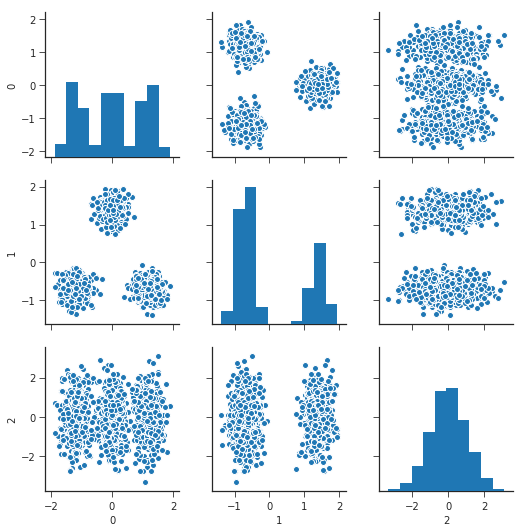

In [11]:
sns.pairplot(pd.DataFrame(X))

In [12]:
d = 3
mi = np.zeros([d, d])
cmi = np.zeros([d, d])
for i, j in tqdm.tqdm([(i, j) for i in range(d) for j in range(d) if i > j]):
    mi[i, j] = mi[j, i] = kliep.mutual_information(X=X[:, i].reshape(-1, 1), Y=X[:, j].reshape(-1, 1), maxiter=1000)
    mask = (np.arange(d) != i) & (np.arange(d) != j)
    mi_xz = kliep.mutual_information(X=X[:, i].reshape(-1, 1), Y=X[:, mask], maxiter=1000)
    mi_yz = kliep.mutual_information(X=X[:, j].reshape(-1, 1), Y=X[:, mask], maxiter=1000)
    mi_xyz = kliep.mutual_information(X=X[:, i].reshape(-1, 1), Y=X[:, j].reshape(-1, 1), Z=X[:, mask], maxiter=1000)
    cmi[i, j] = cmi[j, i] = mi_xyz - (mi_xz + mi_yz)
    cmi[cmi < 0] = 0

cmi

100%|██████████| 3/3 [00:07<00:00,  2.45s/it]


array([[ 0.        ,  0.17161468,  0.        ],
       [ 0.17161468,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]])

In [13]:
model = sklearn.covariance.GraphLasso(alpha=0.1)
model.fit(X)

GraphLasso(alpha=0.1, assume_centered=False, enet_tol=0.0001, max_iter=100,
      mode='cd', tol=0.0001, verbose=False)

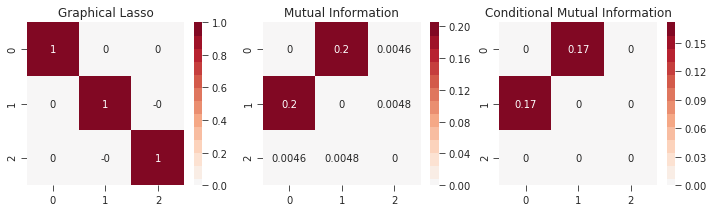

In [14]:
f, axes = plt.subplots(1, 3, figsize=[12, 3])
axes[0].set_title('Graphical Lasso')
axes[1].set_title('Mutual Information')
axes[2].set_title('Conditional Mutual Information')
sns.heatmap(model.precision_, annot=True, ax=axes[0], center=0, cmap=palette)
sns.heatmap(mi, annot=True, ax=axes[1], center=0, cmap=palette)
sns.heatmap(cmi, annot=True, ax=axes[2], center=0, cmap=palette)
plt.savefig('output/cmi2.png', dpi=120)